In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".10"

In [18]:
import pandas as pd
from model import Brain
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import numpy as np
from collections import defaultdict
import re

from lib.sde.grn2 import GRNMain2
from lib.sde.mutate import mutate_grn2
from lib.ga.utils import weighted_selection
from lib.ga.objective import Objective
from jf.profiler import Profiler
from jf.utils.export import Exporter
from jf.autocompute.jf import O
from jf.models.stringmodel import read_model

from lib.sde.gene3 import ParamGene3
from collections import Counter

In [3]:
sm = read_model("generation")

In [4]:
class Solution:
    def __init__(self, grn):
        self.grn = grn
        
    def copy(self):
        return Solution(self.grn.copy())
        
    def mutate(self):
        mutate_grn2(self.grn)

In [5]:
def get_bb(grn):
    ccls = factories["grn3"](grn=grn)
    bb = Brain(time_step=0.5, verbose=False, start_population=5, max_pop_size=1e3,
            cell_cls=ccls, end_time=70, start_time=50, silent=True, record_population=True)
    return bb

In [6]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [7]:
exporter = Exporter(name="objective_0.25_g7_v5")

Exporting at output/objective_0.25_g7_v5


In [8]:
all_generations = {int(sm.extract(x)["generation"]): exporter.load(x) for x in list(filter(sm.match, exporter.list()))}

In [9]:
def get_diff_grn(grn_a, grn_b):
    return list(zip(*np.where(~np.isclose(grn_a._params, grn_b._params))))

In [89]:
grn_a = all_generations[5]["solution"][0].grn
grn_b = all_generations[5]["solution"][4].grn

def get_diff_grn_trees(grn_a, grn_b):
    return [i for i, (t_a, t_b) in enumerate(zip(grn_a.genes, grn_b.genes)) if repr(t_a.tree) != repr(t_b.tree)]

get_diff_grn_trees(grn_a, grn_b)

[3, 6]

In [91]:
# fitness match
def one_delta_fitness(all_generations, generation, min_diff=1., only_pos=False, only_neg=False):
    grns_begin = all_generations[generation]["solution"]
    fitness_begin = all_generations[generation + 1]["fitness"]
    transition = all_generations[generation + 1]["transition"]
    grns_end = all_generations[generation + 1]["solution"]
    fitness_end = all_generations[generation + 2]["fitness"]

    # matching
    ls_matches = []
    for i, prev_id in enumerate(transition):
        if prev_id == -1:
            continue
        grn_a = grns_begin[prev_id].grn
        grn_b = grns_end[i].grn
        delta_fitness = fitness_end[i] - fitness_begin[prev_id]
        diff = get_diff_grn(grn_a, grn_b)
        tree_diff = get_diff_grn_trees(grn_a, grn_b) 
        for x in diff:
            if abs(delta_fitness) < min_diff:
                continue
            if only_pos and delta_fitness < 0:
                continue
            if only_neg and delta_fitness > 0:
                continue
            ls_matches.append((
                grn_a._params[x], grn_b._params[x], ParamGene3[x[0]], x[1], delta_fitness
            ))
            
        for x in tree_diff:
            if abs(delta_fitness) < min_diff:
                continue
            if only_pos and delta_fitness < 0:
                continue
            if only_neg and delta_fitness > 0:
                continue
            ls_matches.append((
                grn_a.genes[x].tree, grn_b.genes[x].tree, "tree", x, delta_fitness
            ))
    
    return ls_matches

In [96]:
def print_matches(matches):
    for match in matches:
        if match[2] == "tree":
            print("{} -> {} for {}_{} : {:.3f}".format(*match))
        else:
            print("{:.3f} -> {:.3f} for {}_{} : {:.3f}".format(*match))

In [109]:
all_matches_pos = []
for generation in range(0, 50):
    # print(f"=== Generation {generation} ===")
    matches = one_delta_fitness(all_generations, generation, min_diff=1.0, only_pos=True)
    # print_matches(matches)
    all_matches_pos += matches

In [99]:
Counter([x[2] for x in all_matches_pos])

Counter({'noise': 26,
         'deg': 22,
         'tree': 175,
         'b': 26,
         'init': 23,
         'expr': 24,
         'm': 24,
         'theta': 14})

In [100]:
Counter([x[3] for x in all_matches_pos])

Counter({5: 57, 1: 11, 2: 54, 0: 34, 3: 49, 6: 70, 4: 59})

In [105]:
Counter([x[3] for x in all_matches_pos if x[2] == "tree"])

Counter({2: 31, 3: 33, 6: 35, 5: 30, 4: 28, 0: 13, 1: 5})

In [101]:
Counter([(x[2], x[3]) for x in all_matches_pos])[("theta", 1)]

0

In [102]:
all_matches = []
for generation in range(0, 50):
    # print(f"=== Generation {generation} ===")
    matches = one_delta_fitness(all_generations, generation, min_diff=1.0, only_neg=True)
    # print_matches(matches)
    all_matches += matches

In [103]:
Counter([x[2] for x in all_matches])

Counter({'tree': 1000,
         'init': 142,
         'theta': 176,
         'noise': 134,
         'm': 144,
         'b': 125,
         'expr': 147,
         'deg': 146})

In [104]:
Counter([x[3] for x in all_matches])

Counter({1: 415, 0: 356, 2: 252, 6: 243, 4: 242, 5: 258, 3: 248})

In [110]:
Counter([x[3] for x in all_matches if x[2] == "tree"])

Counter({1: 197, 0: 193, 2: 115, 6: 118, 4: 119, 5: 131, 3: 127})

In [54]:
Counter([(x[2], x[3]) for x in all_matches])[("theta", 1)]

45

#### Order
Now ask if increase or decrease 

In [64]:
def compare_values(name):
    p1 = [float(x[1] - x[0]) for x in all_matches if x[2] == name]
    p2 = [float(x[1] - x[0]) for x in all_matches_pos if x[2] == name]
    print(np.mean(p1), np.std(p1) / np.sqrt(len(p1)), np.mean(p2), np.std(p2) / np.sqrt(len(p2)))
    plt.hist(p1)
    plt.hist(p2)

1.1001645636885133 0.3418065549118219 -2.0400046543641523 0.8079270579108913


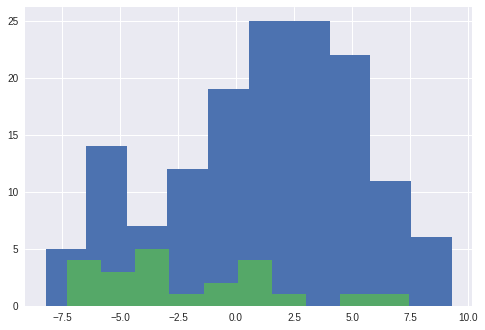

In [65]:
compare_values("deg")

0.3465620937632091 0.2701769537784785 -0.07183531155953041 0.6685463955831075


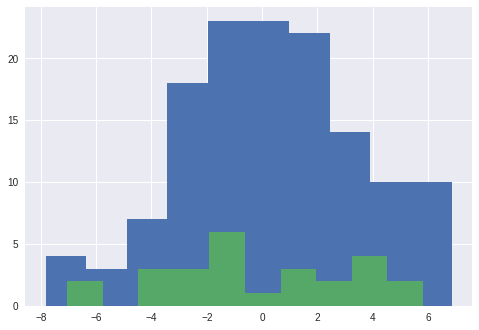

In [66]:
compare_values("noise")

0.3833658742904663 0.3371099263242378 -0.26044471447284406 0.6217481615240005


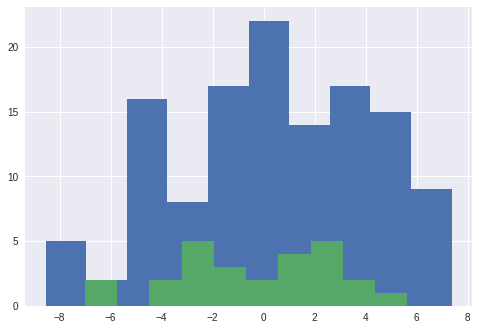

In [67]:
compare_values("b")

0.3975931463970078 0.2604603801606793 0.5878752022981644 0.6719896276181846


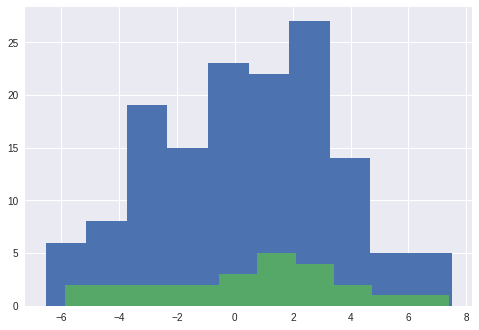

In [68]:
compare_values("m")

0.9915409250692888 0.30680996488666584 1.2491559513977595 1.1054555626589737


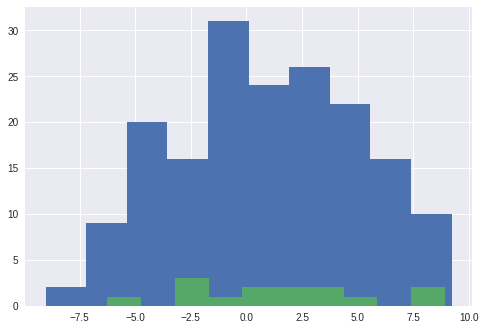

In [69]:
compare_values("theta")

-0.9532782173886591 0.4004386062451739 2.2132526437441506 0.7497274840192807


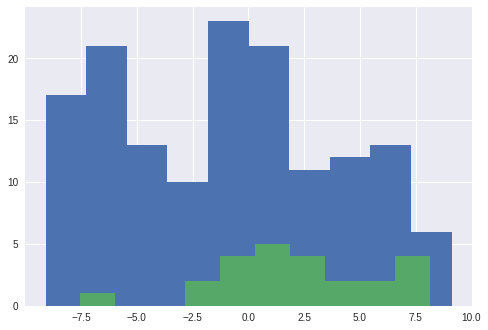

In [70]:
compare_values("expr")

In [72]:
all_generations[70]["solution"][0].grn

>> G_0: init: 0.52; noise: 1.15; b: 2.28; m: 1.17; expr: 9.09; deg: 0.16; theta: 4.45; tree : (((5 OR ((3 OR 0) OR 6)) OR 4) AND 1)
>> G_1: init: 0.50; noise: 4.34; b: 2.45; m: 5.39; expr: 8.31; deg: 1.11; theta: 4.61; tree : 1
>> G_2: init: 2.94; noise: 0.09; b: 3.84; m: 1.89; expr: 6.18; deg: 5.70; theta: 0.11; tree : NOT 2
>> G_3: init: 0.82; noise: 2.67; b: 5.78; m: 4.60; expr: 9.20; deg: 7.70; theta: 5.97; tree : (NOT NOT 3 AND (NOT 6 AND NOT 2))
>> G_4: init: 2.12; noise: 6.23; b: 8.73; m: 7.86; expr: 9.61; deg: 0.65; theta: 5.45; tree : NOT (0 AND 2)
>> G_5: init: 0.67; noise: 3.06; b: 5.08; m: 1.21; expr: 3.47; deg: 0.80; theta: 4.73; tree : NOT NOT 4
>> G_6: init: 2.60; noise: 1.20; b: 1.48; m: 9.95; expr: 3.82; deg: 0.47; theta: 0.71; tree : (NOT (0 OR 4) AND 2)

In [73]:
all_generations[70]["solution"][1].grn

>> G_0: init: 0.52; noise: 5.58; b: 6.81; m: 1.17; expr: 9.09; deg: 0.16; theta: 7.95; tree : 1
>> G_1: init: 0.50; noise: 5.34; b: 2.45; m: 5.39; expr: 7.48; deg: 1.11; theta: 4.61; tree : 4
>> G_2: init: 2.94; noise: 6.26; b: 3.42; m: 4.65; expr: 8.75; deg: 6.63; theta: 7.95; tree : NOT NOT NOT NOT 0
>> G_3: init: 0.03; noise: 7.72; b: 9.87; m: 9.28; expr: 7.98; deg: 1.33; theta: 2.38; tree : NOT (NOT 4 AND (0 AND 3))
>> G_4: init: 1.40; noise: 8.11; b: 2.84; m: 6.43; expr: 4.79; deg: 8.26; theta: 0.24; tree : (NOT (6 AND 2) OR 4)
>> G_5: init: 1.60; noise: 3.06; b: 6.90; m: 6.41; expr: 7.52; deg: 4.41; theta: 7.60; tree : NOT (NOT 2 OR ((6 AND 5) AND 4))
>> G_6: init: 2.60; noise: 4.26; b: 5.71; m: 3.93; expr: 3.31; deg: 1.63; theta: 0.71; tree : (NOT 6 OR 0)

In [74]:
all_generations[70]["solution"][2].grn

>> G_0: init: 0.45; noise: 8.86; b: 6.39; m: 1.17; expr: 5.61; deg: 0.16; theta: 4.31; tree : 2
>> G_1: init: 0.50; noise: 5.34; b: 2.45; m: 5.39; expr: 7.48; deg: 1.11; theta: 4.14; tree : 1
>> G_2: init: 0.50; noise: 6.26; b: 3.42; m: 6.10; expr: 8.75; deg: 4.72; theta: 7.95; tree : NOT NOT (6 AND (1 AND 2))
>> G_3: init: 0.82; noise: 7.72; b: 9.87; m: 4.60; expr: 9.20; deg: 7.70; theta: 2.38; tree : (NOT (NOT 3 AND (0 AND 2)) AND 6)
>> G_4: init: 2.14; noise: 2.84; b: 7.32; m: 6.43; expr: 1.72; deg: 4.24; theta: 0.86; tree : ((NOT 6 AND 1) OR 4)
>> G_5: init: 1.60; noise: 3.06; b: 5.08; m: 6.41; expr: 9.45; deg: 8.31; theta: 7.60; tree : NOT NOT (NOT 2 OR (6 AND 0))
>> G_6: init: 2.60; noise: 4.26; b: 5.71; m: 3.93; expr: 6.95; deg: 1.63; theta: 0.37; tree : NOT 0

In [75]:
all_generations[70]["solution"][3].grn

>> G_0: init: 0.52; noise: 5.58; b: 6.81; m: 4.88; expr: 9.09; deg: 0.16; theta: 7.95; tree : 1
>> G_1: init: 0.50; noise: 5.34; b: 2.45; m: 5.39; expr: 7.48; deg: 1.11; theta: 4.61; tree : 1
>> G_2: init: 2.94; noise: 6.26; b: 3.42; m: 4.65; expr: 8.75; deg: 6.63; theta: 7.95; tree : NOT NOT NOT NOT NOT 0
>> G_3: init: 0.03; noise: 7.72; b: 9.87; m: 9.28; expr: 7.98; deg: 1.33; theta: 2.38; tree : NOT (NOT 4 AND (0 AND 3))
>> G_4: init: 0.80; noise: 8.11; b: 2.84; m: 6.43; expr: 4.79; deg: 8.26; theta: 0.24; tree : (NOT (6 AND 2) OR 4)
>> G_5: init: 1.60; noise: 3.06; b: 6.90; m: 6.41; expr: 7.52; deg: 4.41; theta: 7.60; tree : NOT (NOT 2 OR ((6 AND 5) AND 4))
>> G_6: init: 2.60; noise: 4.26; b: 5.71; m: 3.93; expr: 3.31; deg: 1.63; theta: 0.71; tree : (NOT 6 OR 0)